# Textual Features

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# load the dataset and replace missing values in the 'tweet' column
df = pd.read_csv('removed_training.csv')
df['tweet'] = df['tweet'].fillna('')  # replace NaN with empty strings

# filter the DataFrame to include only rows where gender is 'female' or 'male'
df = df[df['gender'].isin(['female', 'male'])]

# extract tweet text and gender labels
tweets = df['tweet']
gender = df['gender']

# print unique values from the 'gender' column
if 'gender' in df.columns:
    unique_genders = df['gender'].unique()
    print("Unique values in 'gender' column:", unique_genders)
else:
    print("'gender' column not found in the DataFrame.")

Unique values in 'gender' column: ['female' 'male']


In [2]:
# convert tweets to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(tweets)
y = gender

# split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y)

# define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=39, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=39, n_estimators=100),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=39),
    "SVM (Linear Kernel)": SVC(random_state=39, kernel='linear', probability=True)
}

# train and evaluate each classifier
results = {}

for name, clf in classifiers.items():
    print(f"=== {name} ===")
    # train the classifier
    clf.fit(X_train, y_train)
    
    # evaluate on validation data
    y_pred_val = clf.predict(X_val)
    accuracy_val = round(accuracy_score(y_val, y_pred_val), 2)
    
    print("Validation Results:")
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
    print("Classification Report:\n", classification_report(y_val, y_pred_val))
    print("Validation Accuracy:", accuracy_val)
    print()
    
    # store results
    results[name] = {
        "model": clf,
        "accuracy": accuracy_val
    }

=== Logistic Regression ===
Validation Results:
Confusion Matrix:
 [[186  20]
 [ 23 183]]
Classification Report:
               precision    recall  f1-score   support

      female       0.89      0.90      0.90       206
        male       0.90      0.89      0.89       206

    accuracy                           0.90       412
   macro avg       0.90      0.90      0.90       412
weighted avg       0.90      0.90      0.90       412

Validation Accuracy: 0.9

=== Random Forest ===
Validation Results:
Confusion Matrix:
 [[183  23]
 [ 30 176]]
Classification Report:
               precision    recall  f1-score   support

      female       0.86      0.89      0.87       206
        male       0.88      0.85      0.87       206

    accuracy                           0.87       412
   macro avg       0.87      0.87      0.87       412
weighted avg       0.87      0.87      0.87       412

Validation Accuracy: 0.87

=== Gradient Boosting Classifier ===
Validation Results:
Confusion Matr

In [3]:
# load the test dataset and process similarly
df_test = pd.read_csv('removed_test.csv')
df_test['tweet'] = df_test['tweet'].fillna('')  # replace NaN with empty strings

# filter the DataFrame to include only rows where gender is 'female' or 'male'
df_test = df_test[df_test['gender'].isin(['female', 'male'])]

# extract test tweets and gender
tweets_test = df_test['tweet']
gender_test = df_test['gender']


# print unique values from the 'gender' column
if 'gender' in df_test.columns:
    unique_genders = df['gender'].unique()
    print("Unique values in 'gender' column:", unique_genders)
else:
    print("'gender' column not found in the DataFrame.")

Unique values in 'gender' column: ['female' 'male']


In [4]:
# convert test tweets to TF-IDF features
X_test = vectorizer.transform(tweets_test)

# predict and evaluate each classifier on test data
for name, metrics in results.items():
    clf = metrics["model"]
    print(f"=== Test Results for {name} ===")
    y_test_pred = clf.predict(X_test)
    accuracy_test = round(accuracy_score(gender_test, y_test_pred), 2)
    
    print("Confusion Matrix:\n", confusion_matrix(gender_test, y_test_pred))
    print("Classification Report:\n", classification_report(gender_test, y_test_pred))
    print("Test Accuracy:", accuracy_test)
    print()

# feature importance analysis for tree-based models
for name in ["Random Forest", "Gradient Boosting Classifier"]:
    if name in results:
        clf = results[name]["model"]
        feature_importances = clf.feature_importances_
        feature_names = vectorizer.get_feature_names_out()
        
        # create a DataFrame for feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        
        print(f"\n=== Top Features for {name} ===")
        print(importance_df.head(10))
        importance_df.to_csv(f'top_features_{name.replace(" ", "_").lower()}.csv', index=False)


=== Test Results for Logistic Regression ===
Confusion Matrix:
 [[529 131]
 [180 480]]
Classification Report:
               precision    recall  f1-score   support

      female       0.75      0.80      0.77       660
        male       0.79      0.73      0.76       660

    accuracy                           0.76      1320
   macro avg       0.77      0.76      0.76      1320
weighted avg       0.77      0.76      0.76      1320

Test Accuracy: 0.76

=== Test Results for Random Forest ===
Confusion Matrix:
 [[535 125]
 [197 463]]
Classification Report:
               precision    recall  f1-score   support

      female       0.73      0.81      0.77       660
        male       0.79      0.70      0.74       660

    accuracy                           0.76      1320
   macro avg       0.76      0.76      0.76      1320
weighted avg       0.76      0.76      0.76      1320

Test Accuracy: 0.76

=== Test Results for Gradient Boosting Classifier ===
Confusion Matrix:
 [[506 154]
 [16

# Topic Modeling

In [5]:
# import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# extract tweets and labels
tweets_train = df['tweet']
labels_train = df['gender']
tweets_test = df_test['tweet']
labels_test = df_test['gender']

# encode labels if they are not numeric
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# vectorize tweets using CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
tweet_vectors_train = vectorizer.fit_transform(tweets_train)
tweet_vectors_test = vectorizer.transform(tweets_test)

# apply LDA for topic modeling
num_topics = 10  # adjust this number based on dataset
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=39)
lda_features_train = lda_model.fit_transform(tweet_vectors_train)
lda_features_test = lda_model.transform(tweet_vectors_test)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=39),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=39),
    "Random Forest": RandomForestClassifier(random_state=39),
    "SVM": SVC(random_state=39)
}

# train and evaluate each classifier
results = {}

for name, clf in classifiers.items():
    # train the classifier
    clf.fit(lda_features_train, labels_train)
    
    # make predictions on the test set
    predictions = clf.predict(lda_features_test)
    
    # evaluate the model
    accuracy = round(accuracy_score(labels_test, predictions), 2)
    print(f"=== {name} ===")
    print(classification_report(labels_test, predictions, target_names=label_encoder.classes_))
    print(f"Accuracy: {accuracy}")
    print()
    
    # store results for comparison
    results[name] = {"model": clf, "accuracy": accuracy}

# compare performance
for name, metrics in results.items():
    print(f"{name}: Accuracy = {metrics['accuracy']}")

    

=== Logistic Regression ===
              precision    recall  f1-score   support

      female       0.68      0.81      0.74       660
        male       0.76      0.62      0.68       660

    accuracy                           0.71      1320
   macro avg       0.72      0.71      0.71      1320
weighted avg       0.72      0.71      0.71      1320

Accuracy: 0.71

=== Gradient Boosting Classifier ===
              precision    recall  f1-score   support

      female       0.70      0.64      0.67       660
        male       0.67      0.73      0.70       660

    accuracy                           0.69      1320
   macro avg       0.69      0.69      0.68      1320
weighted avg       0.69      0.69      0.68      1320

Accuracy: 0.69

=== Random Forest ===
              precision    recall  f1-score   support

      female       0.72      0.66      0.69       660
        male       0.68      0.74      0.71       660

    accuracy                           0.70      1320
   macro 

In [6]:
import numpy as np

# get the topic-word distributions
topic_word_distributions = lda_model.components_  # shape: (num_topics, num_words)
vocabulary = vectorizer.get_feature_names_out()  # words corresponding to each column in the topic matrix

# function to get top words for a given topic
def get_top_words(topic_idx, n_words=10):
    # get indices of the top words for the topic
    top_word_indices = topic_word_distributions[topic_idx].argsort()[-n_words:][::-1]
    return [vocabulary[i] for i in top_word_indices]

# group topic distributions by labels
topic_distributions_by_label = {label: [] for label in np.unique(labels_train)}

for label, topic_dist in zip(labels_train, lda_features_train):
    topic_distributions_by_label[label].append(topic_dist)

# compute average topic distribution for each label
avg_topic_distribution_by_label = {
    label: np.mean(distributions, axis=0)
    for label, distributions in topic_distributions_by_label.items()
}

# identify the most indicative topics for each label
print("Most indicative topics for each label:\n")
for label, avg_topic_distribution in avg_topic_distribution_by_label.items():
    # get indices of the top topics for the label
    top_topics = avg_topic_distribution.argsort()[-5:][::-1]  # top 5 topics
    print(f"Label {label_encoder.inverse_transform([label])[0]}:")
    for topic_idx in top_topics:
        top_words = get_top_words(topic_idx, n_words=10)
        print(f"  Topic {topic_idx}: {', '.join(top_words)}")
    print()


Most indicative topics for each label:

Label female:
  Topic 8: like, just, don, people, know, ve, time, love, think, good
  Topic 5: day, just, new, happy, love, thanks, good, today, time, night
  Topic 3: trump, just, president, people, vote, amp, like, today, pa, don
  Topic 0: amp, new, social, great, work, data, media, people, today, pa
  Topic 9: amp, great, thanks, today, thank, day, people, new, just, good

Label male:
  Topic 6: just, good, game, like, time, man, team, win, season, ve
  Topic 8: like, just, don, people, know, ve, time, love, think, good
  Topic 3: trump, just, president, people, vote, amp, like, today, pa, don
  Topic 7: just, like, people, think, ve, time, don, commented, brexit, pa
  Topic 5: day, just, new, happy, love, thanks, good, today, time, night



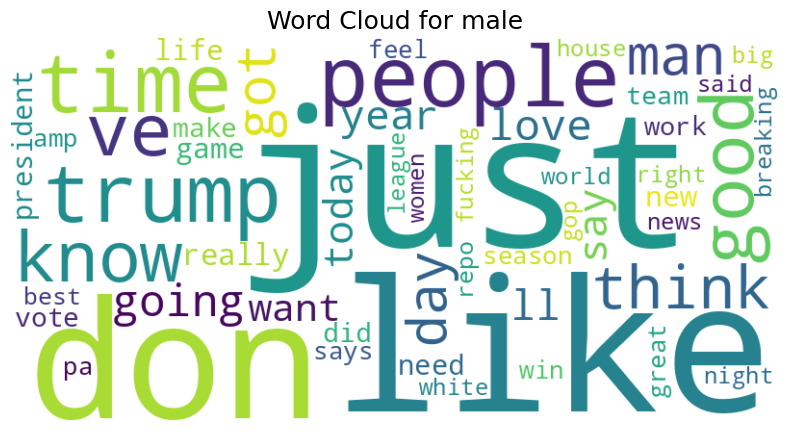

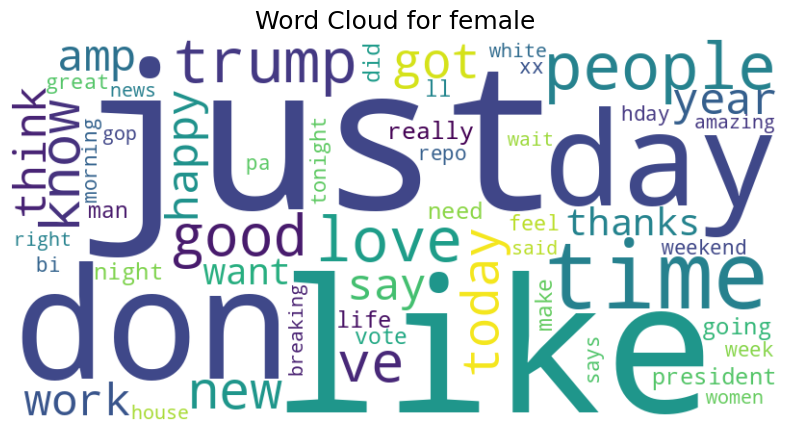

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# get the top words for the most indicative topics for each label
def get_label_words(label, n_topics=3, n_words=25):
    # get the most indicative topics for this label
    avg_topic_distribution = avg_topic_distribution_by_label[label]
    top_topic_indices = avg_topic_distribution.argsort()[-n_topics:][::-1]  # top `n_topics`
    
    # collect top words from these topics
    label_words = {}
    for topic_idx in top_topic_indices:
        top_word_indices = topic_word_distributions[topic_idx].argsort()[-n_words:][::-1]
        for i in top_word_indices:
            word = vocabulary[i]
            weight = topic_word_distributions[topic_idx, i]
            label_words[word] = label_words.get(word, 0) + weight  # sum weights across topics
    
    return label_words

# generate Word Cloud
def create_word_cloud(words, label_name):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white'
    ).generate_from_frequencies(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label_name}", fontsize=18)
    plt.show()

# generate Word Clouds for Bot and Human
male_label = label_encoder.transform(['male'])[0]  # numeric label for "male"
female_label = label_encoder.transform(['female'])[0]  # numeric label for "female"

male_words = get_label_words(male_label)
female_words = get_label_words(female_label)

create_word_cloud(male_words, "male")
create_word_cloud(female_words, "female")


# Emotion Classifier

In [13]:
import re

emoji_pattern = re.compile(
    "["  
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # geometric shapes
    "\U0001F800-\U0001F8FF"  # supplemental arrows
    "\U0001F900-\U0001F9FF"  # aupplemental symbols and pictographs
    "\U0001FA00-\U0001FA6F"  # chess aymbols
    "\U0001FA70-\U0001FAFF"  # aymbols and pictographs
    "\U00002702-\U000027B0"  # dingbats
    "\U000024C2-\U0001F251"  # enclosed characters
    "]", flags=re.UNICODE)


# function to clean tweets: replace mentions, URLs, hashtags, remove multiple spaces, and lowercase
def remove_clean_tweet(tweet):
    tweet = tweet.lower()  # convert tweet to lowercase
    # remove hashtags 
    tweet = re.sub(r'#\S+', ' ', tweet)
    # remove URLs
    tweet = re.sub(r'http[s]?://\S+', ' ', tweet)  # for URLs starting with http:// or https://
    tweet = re.sub(r'www\S+', ' ', tweet)  # for URLs starting with www
    # remove mentions
    tweet = re.sub(r'@\S+', ' ', tweet)  # for mentions like @username
    # add whitespace after emojis
    tweet = re.sub(emoji_pattern, r'\g<0> ', tweet)
    # remove retweets
    tweet = re.sub('rt', ' ', tweet)
    # remove extra spaces and leading/trailing spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # replace multiple spaces with a single space
    return tweet

# load only the first 300 rows of the training data and the first 100 rows of the test data
train_df = pd.read_csv('training.csv', nrows=300)  # first 300 rows of training data
test_df = pd.read_csv('test.csv', nrows=100)  # first 100 rows of test data

# filter datasets for gender 'female' or 'male'
train_df = train_df[train_df['gender'].isin(['female', 'male'])]
test_df = test_df[test_df['gender'].isin(['female', 'male'])]

# preprocess and clean the text data
train_df['removed_text'] = train_df['tweet'].apply(remove_clean_tweet)
test_df['removed_text'] = test_df['tweet'].apply(remove_clean_tweet)


In [14]:
import emoji

# apply emoji.demojize to the 'removed_text' column
train_df['cleaned_text'] = train_df['removed_text'].apply(emoji.demojize)
test_df['cleaned_text'] = test_df['removed_text'].apply(emoji.demojize)

# display the first few rows of the training dataset to confirm
train_df.head()


,tweet,label,gender,removed_text,cleaned_text
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...
5,@lolzdonz @beckyfrancesxo !!!!! @MichelleGreha...,human,female,!!!!! sorry x i fucking love mrs hinch actual ...,!!!!! sorry x i fucking love mrs hinch actual ...
6,@jennycastle96 Ahaha last time acting reckless...,human,male,ahaha last time acting reckless 😂 😂 ahahaha i'...,ahaha last time acting reckless :face_with_tea...
8,I'm so excited for the boojum I'm about to get...,human,female,i'm so excited for the boojum i'm about to get...,i'm so excited for the boojum i'm about to get...


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# load the pre-trained tokenizer and model
model_name = "../BERT-Emotions-Classifier" # change the path to repository depending on your structure
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# define the emotion labels corresponding to the model's outputs
class_labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

def classify_emotions(text):
    # tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # perform emotion classification
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # apply sigmoid to get probabilities for multi-label classification
    probabilities = torch.sigmoid(logits).squeeze().tolist()

    # pair each label with its corresponding score
    results = [{'gender': label, 'score': score} for label, score in zip(class_labels, probabilities)]

    return [results]



In [16]:
# apply the classify_emotions function to the "cleaned_text" column
train_df["emotion_scores"] = train_df["cleaned_text"].apply(classify_emotions)
test_df["emotion_scores"] = test_df["cleaned_text"].apply(classify_emotions)

train_df

,tweet,label,gender,removed_text,cleaned_text,emotion_scores
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...,"[[{'gender': 'anger', 'score': 0.9849827885627..."
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...,"[[{'gender': 'anger', 'score': 0.3502789735794..."
5,@lolzdonz @beckyfrancesxo !!!!! @MichelleGreha...,human,female,!!!!! sorry x i fucking love mrs hinch actual ...,!!!!! sorry x i fucking love mrs hinch actual ...,"[[{'gender': 'anger', 'score': 0.2701514363288..."
6,@jennycastle96 Ahaha last time acting reckless...,human,male,ahaha last time acting reckless 😂 😂 ahahaha i'...,ahaha last time acting reckless :face_with_tea...,"[[{'gender': 'anger', 'score': 0.0234145410358..."
8,I'm so excited for the boojum I'm about to get...,human,female,i'm so excited for the boojum i'm about to get...,i'm so excited for the boojum i'm about to get...,"[[{'gender': 'anger', 'score': 0.3460681736469..."
...,...,...,...,...,...,...
288,cc @HamiltonTrashMo https://t.co/OVpDXSG8c2 @M...,human,male,"cc what really gets me about this story is, if...","cc what really gets me about this story is, if...","[[{'gender': 'anger', 'score': 0.7955543398857..."
289,RT @Sethrogen: Instagram is great because othe...,human,female,instagram is great because otherwise i wouldn’...,instagram is great because otherwise i wouldn’...,"[[{'gender': 'anger', 'score': 0.9040984511375..."
290,@delizabeth5931 @JohnRentoul how is Blur's par...,human,female,how is blur's park life not on there?! thank y...,how is blur's park life not on there?! thank y...,"[[{'gender': 'anger', 'score': 0.9414484500885..."
292,@juter @andybudd @jasonmesut @evalottchen I’m ...,human,male,i’m now asking myself whenever i see a model: ...,i’m now asking myself whenever i see a model: ...,"[[{'gender': 'anger', 'score': 0.9523038268089..."


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

def parse_scores(scores):
        if isinstance(scores, str):
            scores = eval(scores)  # convert string to list of lists
        scores = scores[0]  # flatten the structure
        return {item['gender']: item['score'] for item in scores}
    

# function to parse emotion scores into individual columns
def extract_emotion_scores_new(df):
    emotion_data = pd.DataFrame(df['emotion_scores'].apply(parse_scores).tolist())
    df = pd.concat([df.reset_index(drop=True), emotion_data.reset_index(drop=True)], axis=1)
    return df

# prepare train and test datasets
emotion_train_df = extract_emotion_scores_new(train_df)
emotion_test_df = extract_emotion_scores_new(test_df)

# merge datasets for modeling
data = pd.concat([emotion_train_df, emotion_test_df], axis=0).reset_index(drop=True)

# encode label
label_map = {'female': 0, 'male': 1}
reverse_label_map = {0: 'female', 1: 'male'}  # add reverse mapping for predictions
data['gender'] = data['gender'].map(label_map)

# define features and target
features = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
X = data[features]
y = data['gender']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=39),
    'Gradient Boosting': GradientBoostingClassifier(random_state=39),
    'SVM': SVC(probability=True, random_state=39)
}

# train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # map predictions back to gender labels
    y_pred_gender = [reverse_label_map[pred] for pred in y_pred]

    print(f"=== {model_name} ===")
    print(classification_report(y_test.map(reverse_label_map), y_pred_gender))  # use reverse map for classification report
    print("accuracy score: ", round(accuracy_score(y_test.map(reverse_label_map), y_pred_gender), 2))
    print()

    # store results
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        important_features = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        print(important_features.sort_values(by='Importance', ascending=False).head(5))
        print()


=== Logistic Regression ===
              precision    recall  f1-score   support

      female       0.76      0.48      0.59        27
        male       0.44      0.73      0.55        15

    accuracy                           0.57        42
   macro avg       0.60      0.61      0.57        42
weighted avg       0.65      0.57      0.58        42

accuracy score:  0.57

=== Random Forest ===
              precision    recall  f1-score   support

      female       0.73      0.59      0.65        27
        male       0.45      0.60      0.51        15

    accuracy                           0.60        42
   macro avg       0.59      0.60      0.58        42
weighted avg       0.63      0.60      0.60        42

accuracy score:  0.6

        Feature  Importance
9      surprise    0.115259
1  anticipation    0.111350
3          fear    0.109791
5          love    0.097427
4           joy    0.092976

=== Gradient Boosting ===
              precision    recall  f1-score   support

 

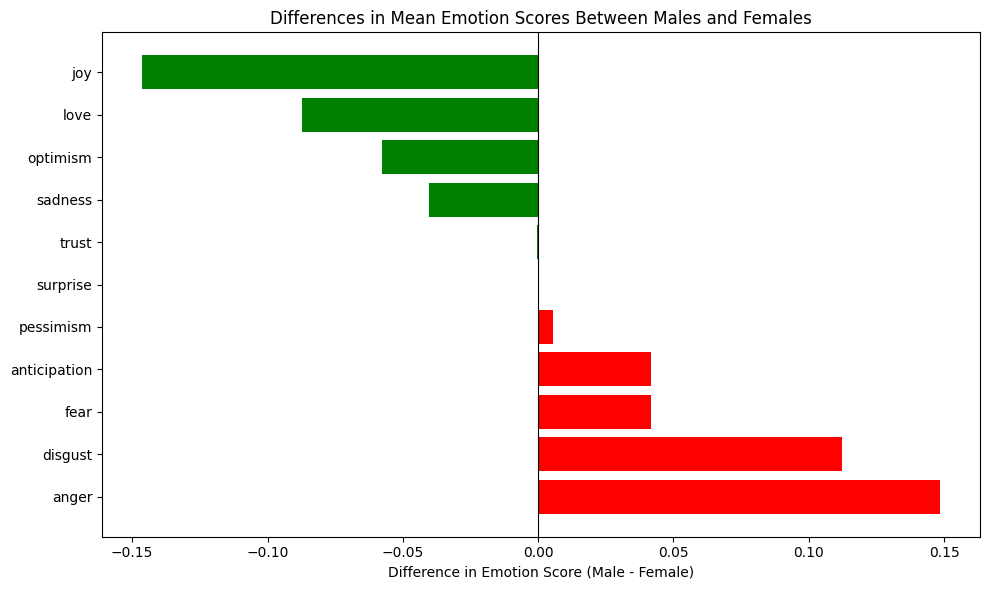

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_emotion_differences(data, features, label_col='gender'):
    """Plot differences in mean emotion scores between male and female."""
    # calculate mean emotion scores by gender (label_col)
    means = data.groupby(label_col)[features].mean()
    
    # calculate the differences (male - female)
    differences = means.loc[1] - means.loc[0]
    
    # sort emotions by the magnitude of differences
    differences = differences.sort_values(ascending=False)

    # prepare plot
    fig, ax = plt.subplots(figsize=(10, 6))
    y = np.arange(len(differences))

    # plotting differences
    ax.barh(y, differences, color=['red' if val > 0 else 'green' for val in differences], align='center')

    ax.set_yticks(y)
    ax.set_yticklabels(differences.index)
    ax.set_xlabel('Difference in Emotion Score (Male - Female)')
    ax.set_title('Differences in Mean Emotion Scores Between Males and Females')
    ax.axvline(0, color='black', linewidth=0.8)  # Line to separate positive and negative

    plt.tight_layout()
    plt.show()

plot_emotion_differences(data, features, label_col='gender')


# POS tags

In [9]:
import pandas as pd
import nltk
from nltk import pos_tag, word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# load the data from CSV files
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df[train_df['gender'].isin(['female', 'male'])]
test_df = test_df[test_df['gender'].isin(['female', 'male'])]

# function to convert text to POS tags
def text_to_pos(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    # extract only POS tags
    pos_sequence = " ".join(tag for _, tag in pos_tags)
    return pos_sequence

# apply the transformation to the training and test data
train_df['pos_tags'] = train_df['tweet'].apply(text_to_pos)
test_df['pos_tags'] = test_df['tweet'].apply(text_to_pos)

# save the transformed data with POS tags to new CSV files
train_df[['pos_tags', 'gender']].to_csv('training_pos_gender.csv', index=False)
test_df[['pos_tags', 'gender']].to_csv('test_pos_gender.csv', index=False)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:992)>


In [10]:
# load the transformed POS-tagged data
train_df = pd.read_csv('training_pos_gender.csv')
test_df = pd.read_csv('test_pos_gender.csv')

# extract the POS sequences (features) and labels (target)
X_train_text = train_df['pos_tags']
y_train = train_df['gender']
X_test_text = test_df['pos_tags']
y_test = test_df['gender']


/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


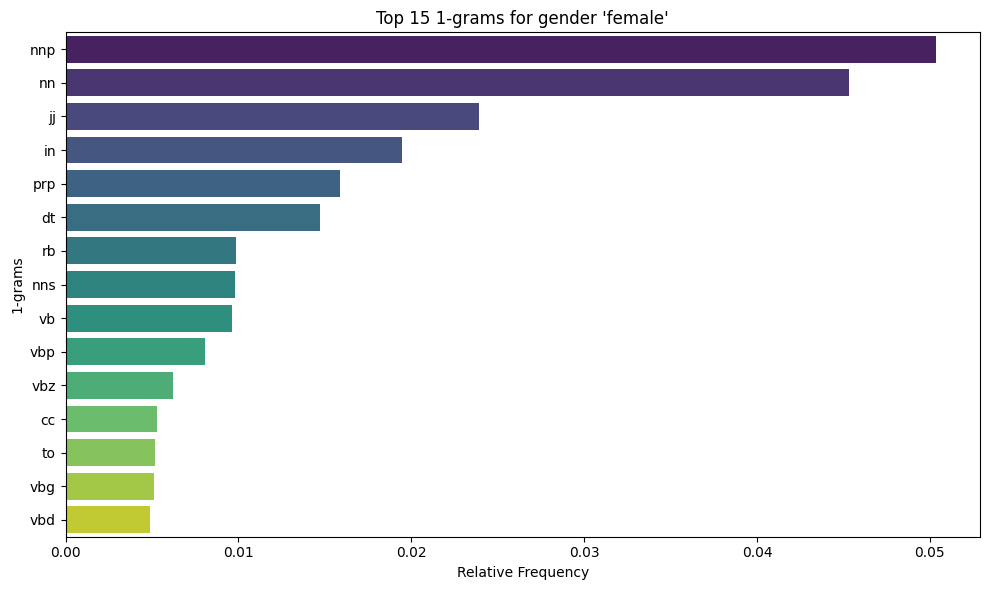

/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


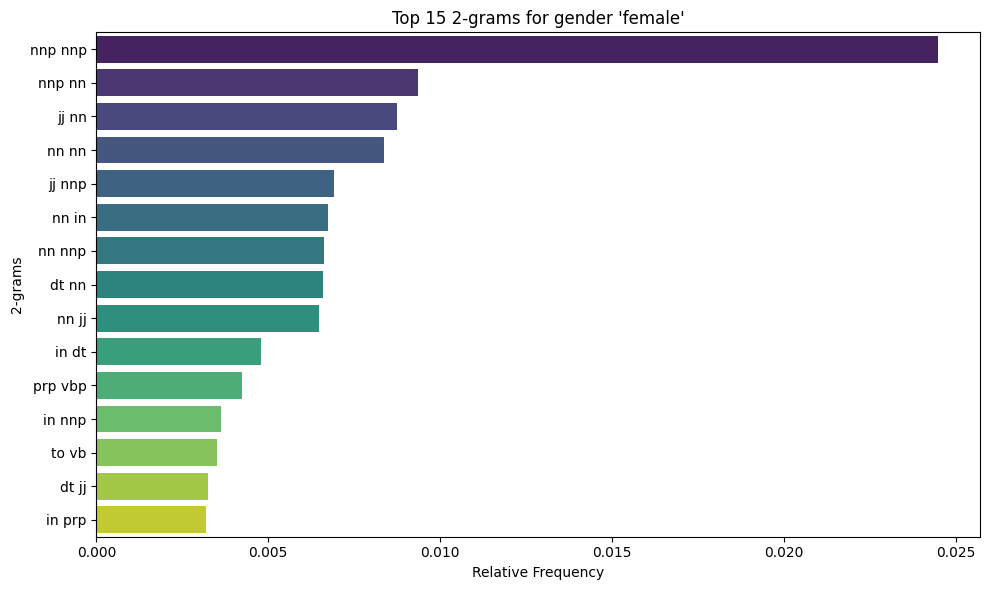

/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


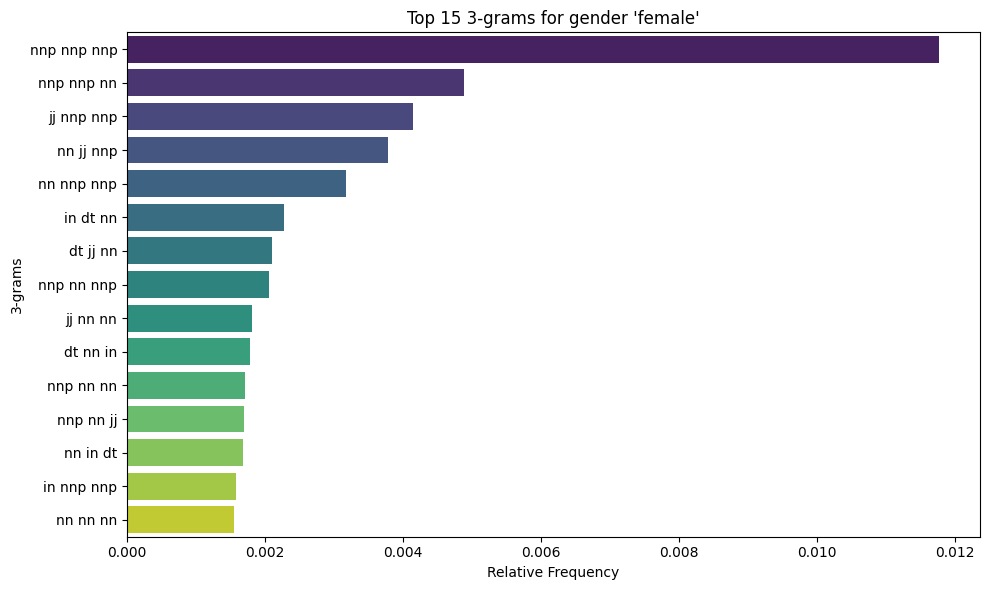

/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


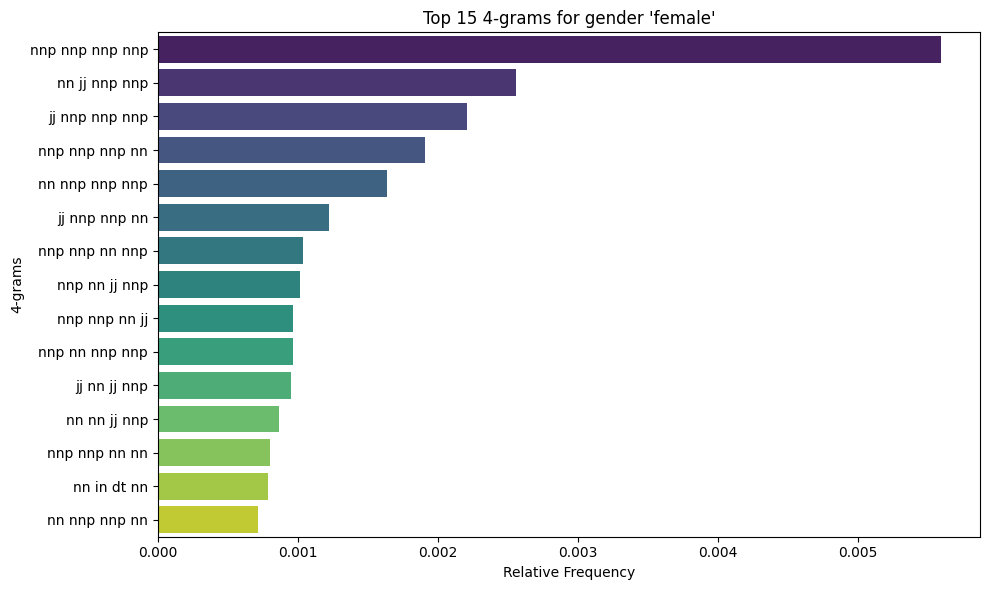

/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


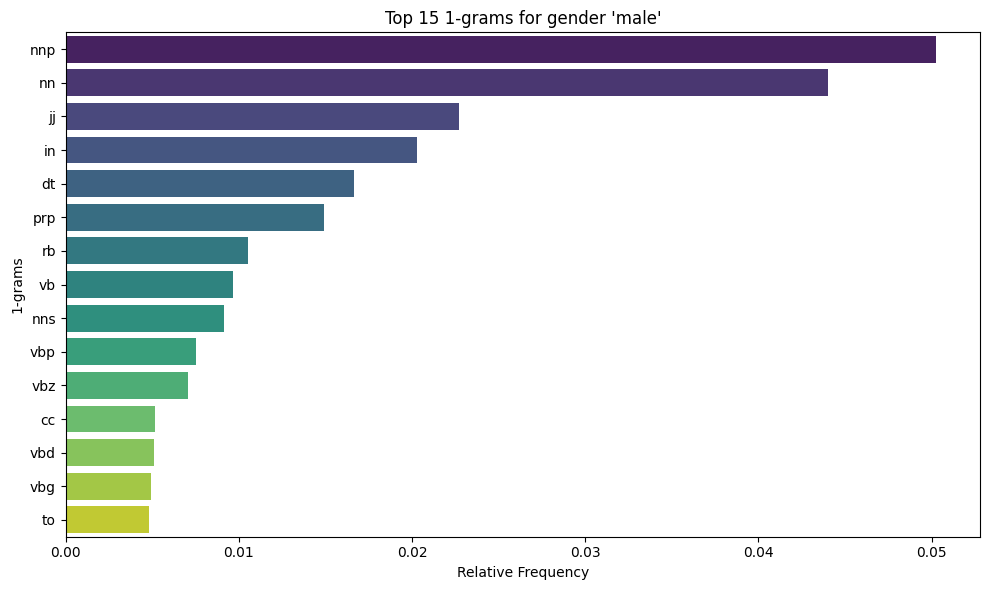

/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


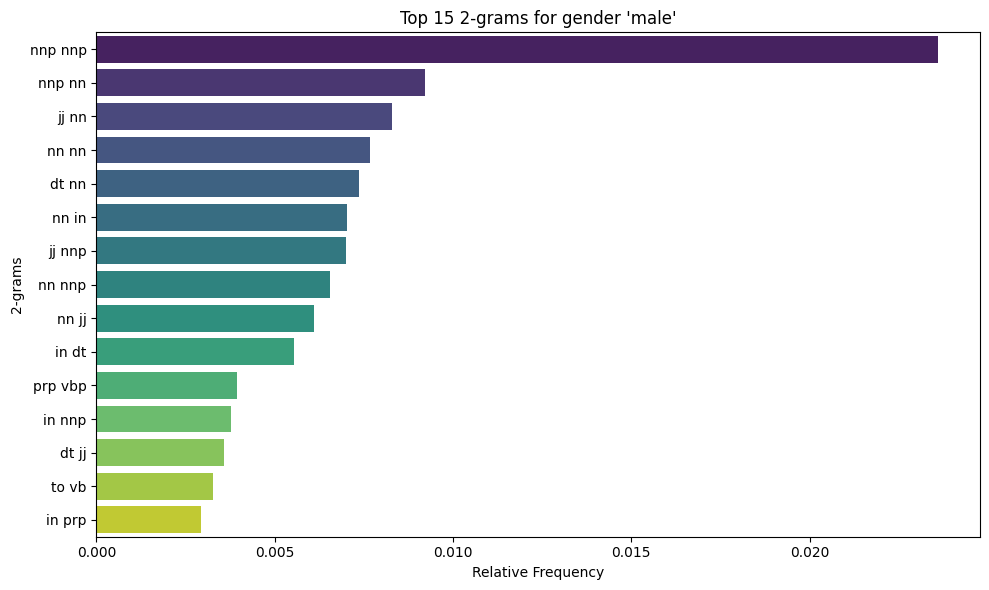

/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


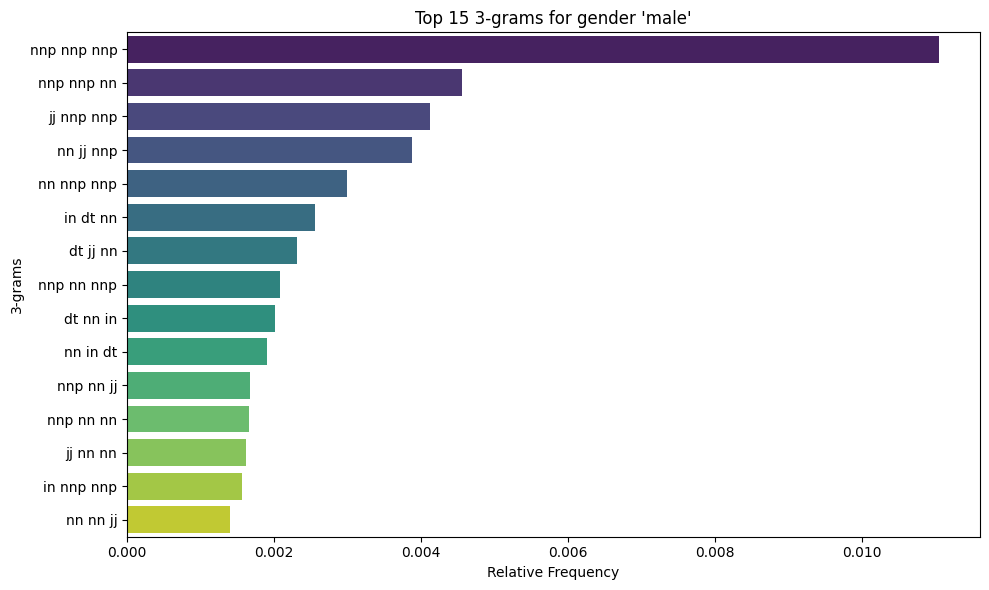

/var/folders/xr/8_04k68n67g0rjkj679cscmh0000gn/T/ipykernel_4791/859594741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=features, palette="viridis", orient="h")


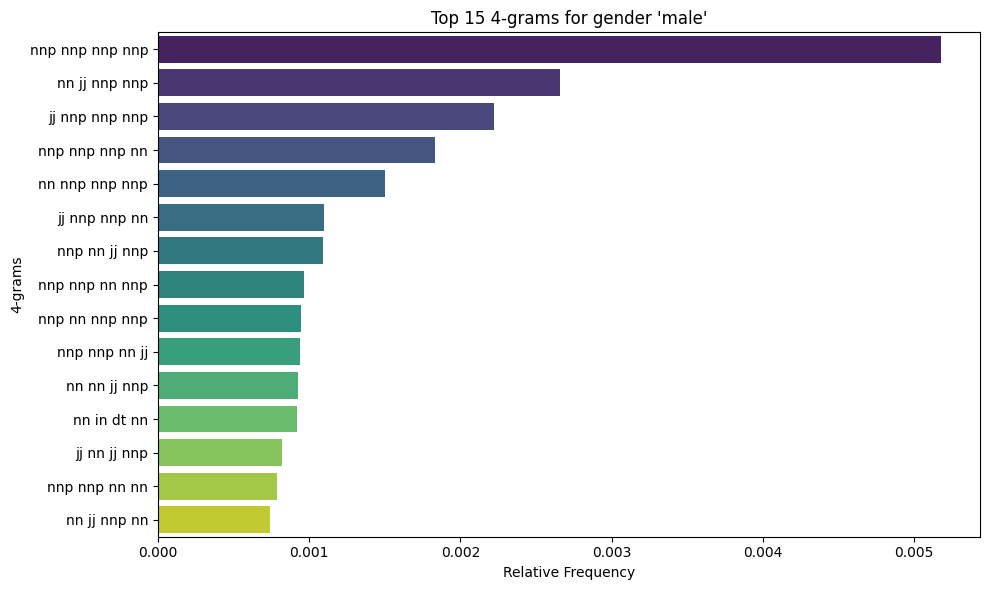

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# compute relative frequencies of n-grams per label
def compute_relative_frequencies(df, label_column, text_column, ngram_range=(1, 4)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, use_idf=False, norm=None, binary=False)
    counts = vectorizer.fit_transform(df[text_column])
    feature_names = vectorizer.get_feature_names_out()
    labels = df[label_column].unique()
    frequencies = {}

    for label in labels:
        label_counts = counts[df[label_column] == label].sum(axis=0)
        label_total = label_counts.sum()
        frequencies[label] = (np.array(label_counts).flatten() / label_total, feature_names)

    return frequencies

# compute relative frequencies for the 'gender' label and 'pos_tags' column
relative_freqs = compute_relative_frequencies(train_df, 'gender', 'pos_tags', ngram_range=(1, 4))

# plot top 15 n-grams per n=1,2,3,4 for each label (gender)
n_values = [1, 2, 3, 4]

def plot_top_ngrams(frequencies, n_values, label):
    for n in n_values:
        # filter n-grams of length 'n'
        ngram_freqs = [(freq, feature) for freq, feature in zip(*frequencies[label]) if len(feature.split()) == n]
        ngram_freqs = sorted(ngram_freqs, reverse=True)[:15]  # select top 15
        freqs, features = zip(*ngram_freqs)  # unzip the list of tuples

        # plot the n-grams
        plt.figure(figsize=(10, 6))
        sns.barplot(x=freqs, y=features, palette="viridis", orient="h")
        plt.title(f"Top 15 {n}-grams for gender '{label}'")
        plt.xlabel("Relative Frequency")
        plt.ylabel(f"{n}-grams")
        plt.tight_layout()
        plt.show()

# plot top n-grams for each label (gender)
for label in relative_freqs:
    plot_top_ngrams(relative_freqs, n_values, label)


In [12]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# fit the vectorizer on the training data and transform the training set
vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_features=5000, stop_words='english')

# fit on the training data
X_train = vectorizer.fit_transform(train_df['pos_tags'])
y_train = train_df['gender']

# transform the test data using the already fitted vectorizer
X_test = vectorizer.transform(test_df['pos_tags'])
y_test = test_df['gender']

In [13]:
# initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=39, max_iter=500),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=39),
    "Random Forest": RandomForestClassifier(random_state=39),
    "SVM": SVC(random_state=39)
}

# train and evaluate each classifier
for name, clf in classifiers.items():
    # train the classifier
    clf.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # evaluate the model
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
    print()

    # if the classifier has coefficients (like Logistic Regression), show top features
    if hasattr(clf, "coef_"):
        coefficients = clf.coef_[0]  # for binary classification, it's a single row
        features = np.array(vectorizer.get_feature_names_out())
        top_indices = np.argsort(np.abs(coefficients))[-5:][::-1]  # top 5 by absolute value of importance
        print(f"Top 5 Features for {name}:")
        for i in top_indices:
            print(f"{features[i]}: {coefficients[i]:.4f}")
        print()
    
    # if it's Random Forest or Gradient Boosting, show feature importances
    elif hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        feature_names = vectorizer.get_feature_names_out()
        top_indices = np.argsort(importances)[-5:][::-1]  # top 5 by importance
        print(f"Top 5 Features for {name}:")
        for i in top_indices:
            print(f"{feature_names[i]}: {importances[i]:.4f}")
        print()


=== Logistic Regression ===
              precision    recall  f1-score   support

      female       0.65      0.62      0.63       660
        male       0.64      0.66      0.65       660

    accuracy                           0.64      1320
   macro avg       0.64      0.64      0.64      1320
weighted avg       0.64      0.64      0.64      1320

Accuracy: 0.64

Top 5 Features for Logistic Regression:
dt: 5.5877
vbz: 2.5281
nnp: 2.5082
dt nn: 2.3076
prp: -2.0273

=== Gradient Boosting Classifier ===
              precision    recall  f1-score   support

      female       0.64      0.64      0.64       660
        male       0.64      0.65      0.64       660

    accuracy                           0.64      1320
   macro avg       0.64      0.64      0.64      1320
weighted avg       0.64      0.64      0.64      1320

Accuracy: 0.64

Top 5 Features for Gradient Boosting Classifier:
vbz dt: 0.0627
prp nn: 0.0448
rb jj: 0.0305
dt: 0.0302
nnp nnp nns: 0.0287

=== Random Forest ===

# Emotion Classification Grouping

In [1]:
import re

# define positive, negative, and heart emoji groups
positive_emojis = [
    "😀", "😃", "😄", "😁", "😆", "😂", "🤣", "☺️", "😊", "😇", "🙂", "🙃", "😌", 
    "😍", "🥰", "😗", "😙", "😘", "😚", "😋", "😛", "😝", "😜", "🤪", "🤩", "🥳", 
    "🤗", "🤭", "👍"
]

negative_emojis = [
    "🤢", "🤮", "😥", "😰", "😭", "😢", "😖", "😣", "☹️", "🙁", "😕", "😟", "😔", 
    "😞", "👎", "💔"
]

heart_emojis = [
    "🫰", "🫶", "🩷", "❤️", "🧡", "💛", "💚", "🩵", "💙", "💜", "🖤", "🩶", "🤍", 
    "🤎", "❤️‍🔥", "❣️", "💕", "💞", "💓", "💗", "💖", "💘", "💝", "💟"
]

# function to replace emoji with a category
def replace_emoji(match):
    emoji_char = match.group(0)
    # check the emoji against the defined groups
    if emoji_char in positive_emojis:
        return "smiling_emoji"
    elif emoji_char in negative_emojis:
        return "sad_emoji"
    elif emoji_char in heart_emojis:
        return "heart"
    else:
        return "emoji"  # default for any other emoji
    
emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # miscellaneous symbols and pictographs
        u'\U0001F680-\U0001F6FF'  # transport and map symbols
        u'\U0001F700-\U0001F77F'  # alchemical symbols
        u'\U0001F780-\U0001F7FF'  # geometric shapes
        u'\U0001F800-\U0001F8FF'  # supplemental arrows
        u'\U0001F900-\U0001F9FF'  # supplemental symbols and pictographs
        u'\U0001FA00-\U0001FA6F'  # chess symbols
        u'\U0001FA70-\U0001FAFF'  # symbols and pictographs
        u'\U00002702-\U000027B0'  # dingbats
        u'\U0001F004-\U0001F0CF'  # playing cards
        u'\U0001F201-\U0001F251'  # enclosed characters
        ']+', flags=re.UNICODE)

def group_emojis(text):
    # use regex to find all emojis in the text
    grouped_text = emoji_pattern.sub(replace_emoji, text)
    
    return grouped_text


In [2]:
import pandas as pd

# function to clean tweets: replace mentions, URLs, hashtags, remove multiple spaces, and lowercase
def remove_clean_tweet(tweet):
    tweet = tweet.lower()  # convert tweet to lowercase
    # remove hashtags 
    tweet = re.sub(r'#\S+', ' ', tweet)
    # remove URLs
    tweet = re.sub(r'http[s]?://\S+', ' ', tweet)  # for URLs starting with http:// or https://
    tweet = re.sub(r'www\S+', ' ', tweet)  # for URLs starting with www
    # remove mentions
    tweet = re.sub(r'@\S+', ' ', tweet)  # for mentions like @username
    # add whitespace after emojis
    tweet = re.sub(emoji_pattern, r'\g<0> ', tweet)
    # remove retweets
    tweet = re.sub('rt', ' ', tweet)
    # remove extra spaces and leading/trailing spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # replace multiple spaces with a single space
    return tweet

# load data from CSV files
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df.loc[train_df['gender'].isin(['male', 'female'])]
test_df = test_df.loc[test_df['gender'].isin(['male', 'female'])]

# limit to the first 300 rows for train_df and first 100 rows for test_df
train_df = train_df.iloc[:300]
test_df = test_df.iloc[:100]

# preprocess and clean the text data
train_df['removed_text'] = train_df['tweet'].apply(remove_clean_tweet)
test_df['removed_text'] = test_df['tweet'].apply(remove_clean_tweet)



In [3]:
# apply emoji.demojize to the 'text' column
train_df['cleaned_text'] = train_df['removed_text'].apply(group_emojis)
test_df['cleaned_text'] = test_df['removed_text'].apply(group_emojis)
train_df.head()

,tweet,label,gender,removed_text,cleaned_text
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...
5,@lolzdonz @beckyfrancesxo !!!!! @MichelleGreha...,human,female,!!!!! sorry x i fucking love mrs hinch actual ...,!!!!! sorry x i fucking love mrs hinch actual ...
6,@jennycastle96 Ahaha last time acting reckless...,human,male,ahaha last time acting reckless 😂😂 ahahaha i'v...,ahaha last time acting reckless emoji ahahaha ...
8,I'm so excited for the boojum I'm about to get...,human,female,i'm so excited for the boojum i'm about to get...,i'm so excited for the boojum i'm about to get...


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# load the pre-trained tokenizer and model
model_name = "../BERT-Emotions-Classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define the emotion labels corresponding to your model's outputs
class_labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

def classify_emotions(text):
    # tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # perform emotion classification
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # apply sigmoid to get probabilities for multi-label classification
    probabilities = torch.sigmoid(logits).squeeze().tolist()

    # pair each label with its corresponding score
    results = [{'gender': gender, 'score': score} for gender, score in zip(class_labels, probabilities)]

    return [results]



In [5]:
# apply the classify_emotions function to the "cleaned_text" column
train_df["emotion_scores_new"] = train_df["cleaned_text"].apply(classify_emotions)
test_df["emotion_scores_new"] = test_df["cleaned_text"].apply(classify_emotions)

train_df

,tweet,label,gender,removed_text,cleaned_text,emotion_scores_new
0,Alex is too nice for love island :( RT @STVNew...,human,female,alex is too nice for love island :( teenager c...,alex is too nice for love island :( teenager c...,"[[{'gender': 'anger', 'score': 0.9830276966094..."
1,RT @AlexanderRugaev: The Crypto Finance Ecosys...,human,female,the crypto finance ecosystem by women are not ...,the crypto finance ecosystem by women are not ...,"[[{'gender': 'anger', 'score': 0.3502789735794..."
5,@lolzdonz @beckyfrancesxo !!!!! @MichelleGreha...,human,female,!!!!! sorry x i fucking love mrs hinch actual ...,!!!!! sorry x i fucking love mrs hinch actual ...,"[[{'gender': 'anger', 'score': 0.6797894239425..."
6,@jennycastle96 Ahaha last time acting reckless...,human,male,ahaha last time acting reckless 😂😂 ahahaha i'v...,ahaha last time acting reckless emoji ahahaha ...,"[[{'gender': 'anger', 'score': 0.6565812230110..."
8,I'm so excited for the boojum I'm about to get...,human,female,i'm so excited for the boojum i'm about to get...,i'm so excited for the boojum i'm about to get...,"[[{'gender': 'anger', 'score': 0.3681014180183..."
...,...,...,...,...,...,...
598,Jacob feeling a bit like me in the heat... htt...,human,male,jacob feeling a bit like me in the heat... but...,jacob feeling a bit like me in the heat... but...,"[[{'gender': 'anger', 'score': 0.7512922286987..."
599,I've seen scarier episodes of Peppa Pig than T...,human,female,i've seen scarier episodes of peppa pig than t...,i've seen scarier episodes of peppa pig than t...,"[[{'gender': 'anger', 'score': 0.9732375741004..."
605,@niamhmacmillan1 miss u more ☹️☹️ I’m so excit...,human,female,miss u more ☹️☹️ i’m so excited !! xox awww i ...,miss u more ☹️☹️ i’m so excited !! xox awww i ...,"[[{'gender': 'anger', 'score': 0.0454297624528..."
608,I have to be in my boy Buddens corner for this...,human,male,i have to be in my boy buddens corner for this...,i have to be in my boy buddens corner for this...,"[[{'gender': 'anger', 'score': 0.9797146916389..."


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

def parse_scores(scores):
        if isinstance(scores, str):
            scores = eval(scores)  # convert string to list of lists
        scores = scores[0]  # flatten the structure
        return {item['gender']: item['score'] for item in scores}

# function to parse emotion scores into individual columns
def extract_emotion_scores_new(df):
    emotion_data = pd.DataFrame(df['emotion_scores_new'].apply(parse_scores).tolist())
    df = pd.concat([df.reset_index(drop=True), emotion_data.reset_index(drop=True)], axis=1)
    return df

# prepare train and test datasets
emotion_train_df = extract_emotion_scores_new(train_df)
emotion_test_df = extract_emotion_scores_new(test_df)

# merge datasets for modeling
data = pd.concat([emotion_train_df, emotion_test_df], axis=0).reset_index(drop=True)

# encode label
label_map = {'female': 0, 'male': 1}
reverse_label_map = {0: 'female', 1: 'male'}  # add reverse mapping for predictions
data['gender'] = data['gender'].map(label_map)

# define features and target
features = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
X = data[features]
y = data['gender']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=39),
    'Gradient Boosting': GradientBoostingClassifier(random_state=39),
    'SVM': SVC(probability=True, random_state=39)
}

# train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # map predictions back to gender labels
    y_pred_gender = [reverse_label_map[pred] for pred in y_pred]

    print(f"=== {model_name} ===")
    print(classification_report(y_test.map(reverse_label_map), y_pred_gender))  # use reverse map for classification report
    print("accuracy score: ", round(accuracy_score(y_test.map(reverse_label_map), y_pred_gender), 2))
    print()

    # store results
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        important_features = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        print(important_features.sort_values(by='Importance', ascending=False).head(5))
        print()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
=== Logistic Regression ===
              precision    recall  f1-score   support

      female       0.59      0.50      0.54        38
        male       0.60      0.69      0.64        42

    accuracy                           0.60        80
   macro avg       0.60      0.60      0.59        80
weighted avg       0.60      0.60      0.60        80

accuracy score:  0.6

=== Random Forest ===
              precision    recall  f1-score   support

      female       0.48      0.55      0.51        38
        male       0.53      0.45      0.49        42

    accuracy                           0.50        80
   macro avg       0.50      0.50      0.50        80
weigh

# Feature Counts

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:992)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>



=== Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

      female       0.58      0.56      0.57       660
        male       0.58      0.60      0.59       660

    accuracy                           0.58      1320
   macro avg       0.58      0.58      0.58      1320
weighted avg       0.58      0.58      0.58      1320

Confusion Matrix:
[[369 291]
 [262 398]]
Accuracy: 0.58

Top Features:
                Feature  Importance
2          tweet_length    1.682107
0        sentence_count    0.476171
6         mention_count    0.185937
12          swear_count    0.179573
5             url_count    0.127848
9       adjective_count   -0.114031
4           emoji_count   -0.127122
3         hashtag_count   -0.228279
10         adverb_count   -0.234491
1   avg_sentence_length   -0.353198


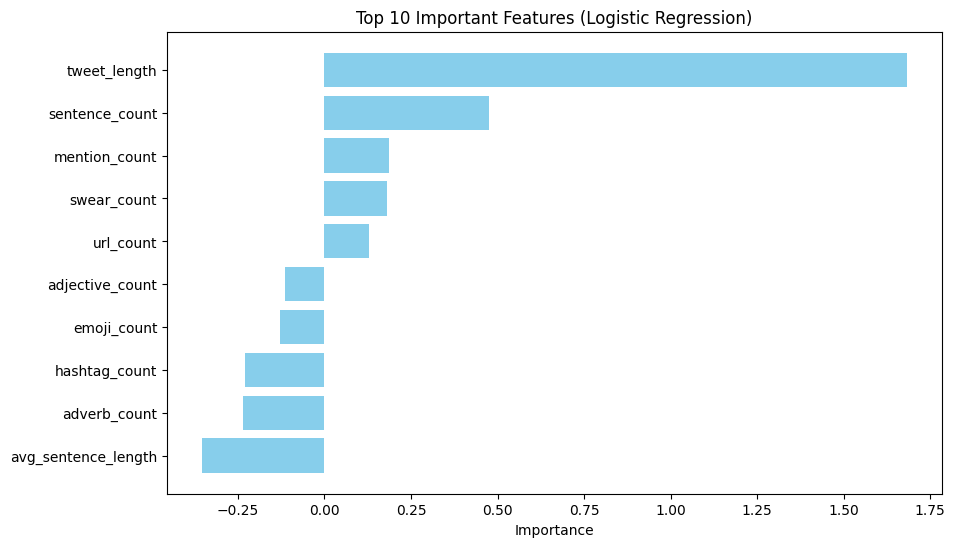


=== Random Forest ===

Classification Report:
              precision    recall  f1-score   support

      female       0.55      0.53      0.54       660
        male       0.54      0.56      0.55       660

    accuracy                           0.54      1320
   macro avg       0.54      0.54      0.54      1320
weighted avg       0.54      0.54      0.54      1320

Confusion Matrix:
[[350 310]
 [291 369]]
Accuracy: 0.54

Top Features:
                Feature  Importance
1   avg_sentence_length    0.105091
3         hashtag_count    0.098664
4           emoji_count    0.097671
7            noun_count    0.092973
0        sentence_count    0.080905
6         mention_count    0.075606
11            sentiment    0.075330
2          tweet_length    0.072910
8            verb_count    0.065310
10         adverb_count    0.064790


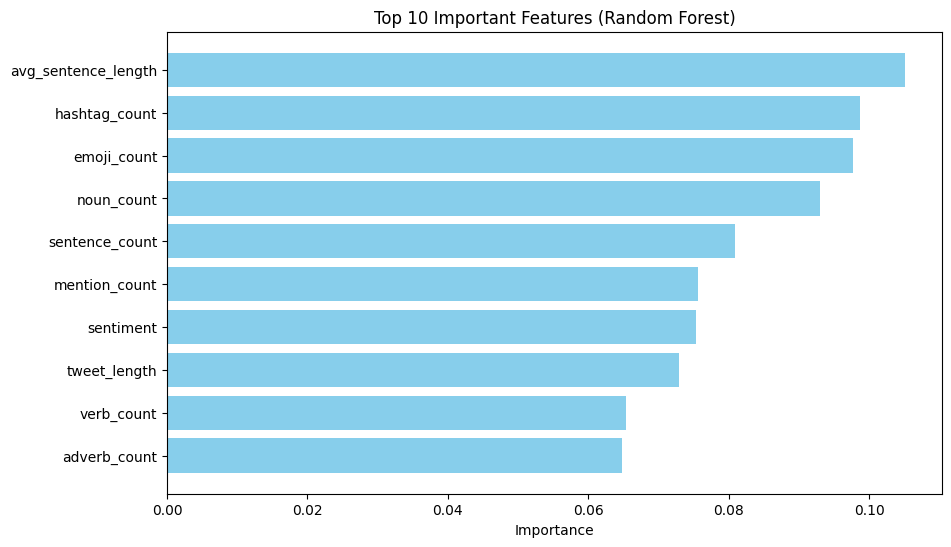


=== Support Vector Machine ===

Classification Report:
              precision    recall  f1-score   support

      female       0.59      0.57      0.58       660
        male       0.58      0.60      0.59       660

    accuracy                           0.59      1320
   macro avg       0.59      0.59      0.59      1320
weighted avg       0.59      0.59      0.59      1320

Confusion Matrix:
[[377 283]
 [264 396]]
Accuracy: 0.59

Top Features:
                Feature  Importance
2          tweet_length    2.173421
7            noun_count    1.703017
8            verb_count    1.278807
0        sentence_count    0.474654
1   avg_sentence_length    0.407072
11            sentiment    0.347922
10         adverb_count    0.283228
12          swear_count    0.249069
9       adjective_count    0.242383
3         hashtag_count    0.241894


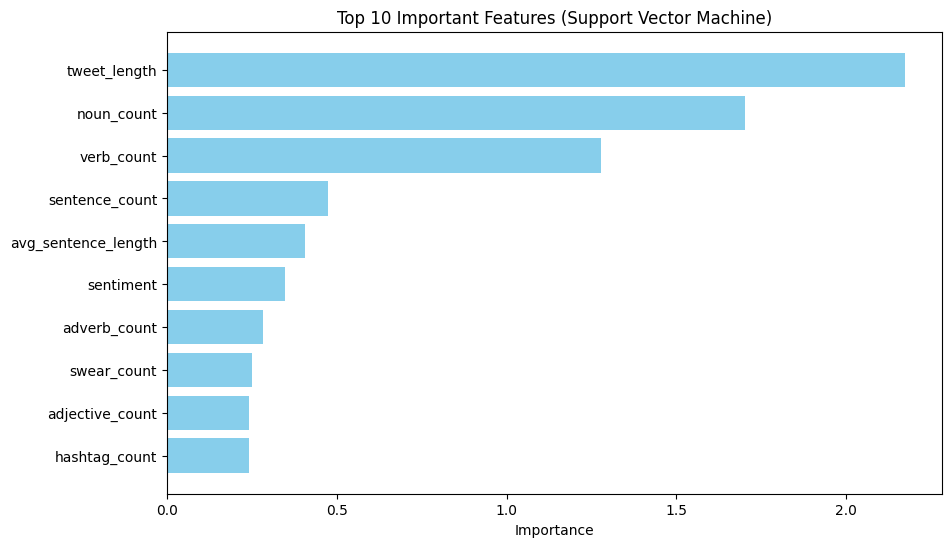


=== Gradient Boosting Classifier ===

Classification Report:
              precision    recall  f1-score   support

      female       0.59      0.57      0.58       660
        male       0.58      0.60      0.59       660

    accuracy                           0.58      1320
   macro avg       0.58      0.58      0.58      1320
weighted avg       0.58      0.58      0.58      1320

Confusion Matrix:
[[378 282]
 [267 393]]
Accuracy: 0.58

Top Features:
                Feature  Importance
1   avg_sentence_length    0.170503
3         hashtag_count    0.136915
4           emoji_count    0.131995
7            noun_count    0.091907
8            verb_count    0.073892
12          swear_count    0.071979
6         mention_count    0.066864
11            sentiment    0.064054
9       adjective_count    0.049886
10         adverb_count    0.048896


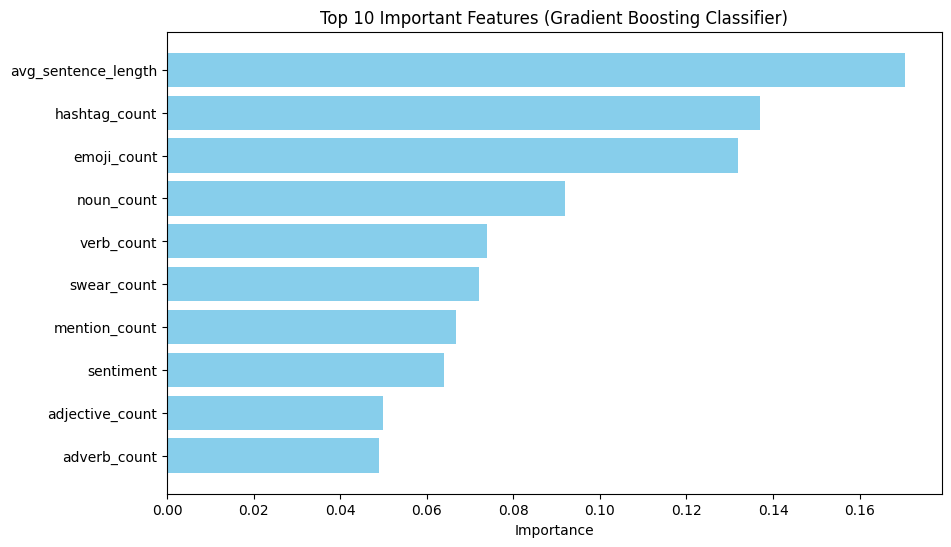

In [1]:
import pandas as pd
import re
import nltk
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

# define sexual/swear words (example list) (generated via chatgpt)
# (i generated them by chatgpt using: "give me a list of swearwords, also with ways that people write them online like b00bies and so on" on 04.10.2024, 14:10)
swear_words = set([
    "damn", "hell", "crap", "shit", "fuck", "bitch", "bastard", "asshole", "dick", "piss", 
    "whore", "slut", "cunt", "freak", "prick", "arse", "bloody", "bugger", 
    "f*ck", "sh*t", "b*tch", "a**hole", "b@stard", "d@mn", "h3ll",
    "d1ck", "f@ck", "sht", "bch", "cnt", "wh0re", "sl*t", "a$$", "d@mmit", 
    "b00bs", "b00bies", "fuk", "fukk", "sh1t", "fuq", "biatch", "beeyotch", 
    "a55", "azzhole", "azz", "mofo", "muthafucka", "mutha", "phuck", 
    "phuq", "phuk", "c*nt", "n00b", "wtf", "lmfao", "lmao", 
    "omfg", "gtfo", "wth", "wtaf", "douchebag", "douchetard", 
    "boobies", "boobs", "tits", "tit", "dong", "dildo", "blowjob", 
    "handjob", "anal", "buttplug", "clit", "cum", "cummies", "vagina", 
    "penis", "sex", "sexy", "threesome", "orgy", "masturbate", 
    "porn", "porno", "p0rn", "s3x", "horny", "lust", "nsfw", 
    "tosser", "wanker", "knob", "bellend", "pillock", "git", "twat", 
    "plonker", "shagger", "gobshite", "scumbag", 
    "n*gga", "n*gger", "chink", "f*ggot", "k*ke", "sp*c", "cracker", 
    "wetback", "paki", "sandn*gger", "raghead", "gook", "69","420","fk","fkin"
])

# function to count word types using NLTK's POS tagging
def pos_counts(tweet):
    tokens = word_tokenize(tweet)
    pos_tags = nltk.pos_tag(tokens)
    noun_count = sum(1 for _, pos in pos_tags if pos.startswith('NN'))  # nouns
    verb_count = sum(1 for _, pos in pos_tags if pos.startswith('VB'))  # verbs
    adjective_count = sum(1 for _, pos in pos_tags if pos.startswith('JJ'))  # adjectives
    adverb_count = sum(1 for _, pos in pos_tags if pos.startswith('RB'))  # adverbs
    return noun_count, verb_count, adjective_count, adverb_count

# function to extract features from a single tweet
def extract_features(tweet):
    # sentence count and average sentence length
    sentences = nltk.sent_tokenize(tweet)
    sentence_count = len(sentences)
    avg_sentence_length = len(tweet.split()) / sentence_count if sentence_count > 0 else 0

    # tweet length
    tweet_length = len(tweet.split())

    # count hashtags, emojis, URLs, mentions
    hashtag_count = len(re.findall(r'HASHTAG', tweet))
    emoji_count = len(re.findall(r'EMOJI', tweet))
    url_count = len(re.findall(r'URL', tweet))
    mention_count = len(re.findall(r'MENTION', tweet))

    # part-of-speech counts
    noun_count, verb_count, adjective_count, adverb_count = pos_counts(tweet)

    # sentiment analysis
    sentiment = TextBlob(tweet).sentiment.polarity

    # count swear words
    swear_count = sum(1 for word in tweet.split() if word in swear_words)

    return {
        'sentence_count': sentence_count,
        'avg_sentence_length': avg_sentence_length,
        'tweet_length': tweet_length,
        'hashtag_count': hashtag_count,
        'emoji_count': emoji_count,
        'url_count': url_count,
        'mention_count': mention_count,
        'noun_count': noun_count,
        'verb_count': verb_count,
        'adjective_count': adjective_count,
        'adverb_count': adverb_count,
        'sentiment': sentiment,
        'swear_count': swear_count
    }

# load cleaned data
df_features = pd.read_csv('tweets_with_features.csv')

# filter rows where gender is either 'female' or 'male'
df_features = df_features[df_features['gender'].isin(['female', 'male'])]

# separate features and labels
X = df_features.drop(columns=['label', 'tweet', 'gender'])  # drop label, tweet, and gender columns
y = df_features['gender']  # predicting gender (female, male)

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y)

# scale features (optional for tree-based models but necessary for LR and SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# load test set
df_test = pd.read_csv('tweets_with_features_test.csv')
df_test = df_test[df_test['gender'].isin(['female', 'male'])]  # filter gender in test set

X_test = df_test.drop(columns=['tweet', 'gender', 'label'])
y_test = df_test['gender']
X_test = scaler.transform(X_test)  # scale test features

# initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=39, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=39, n_estimators=100),
    "Support Vector Machine": SVC(random_state=39, kernel='linear', probability=True),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=39)
}

# train, evaluate, and display results
for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    
    # train the model
    model.fit(X_train, y_train)

    # predict on test data
    test_predictions = model.predict(X_test)
    
    # evaluate the model on test data
    print("\nClassification Report:")
    print(classification_report(y_test, test_predictions))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, test_predictions))

    accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy: {accuracy:.2f}")
    
    # feature importance analysis
    print("\nTop Features:")

    if model_name == "Logistic Regression":
        # for LR, use coefficients
        coefficients = model.coef_[0]
        features = X.columns
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': coefficients
        }).sort_values(by='Importance', ascending=False)
    
    elif model_name == "Support Vector Machine":
        # for SVM, use absolute coefficients
        coefficients = model.coef_[0]
        features = X.columns
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': abs(coefficients)
        }).sort_values(by='Importance', ascending=False)
    
    else:
        # for tree-based models, use feature_importances_
        feature_importances = model.feature_importances_
        features = X.columns
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

    # display top 10 features
    print(importance_df.head(10))

    # plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f'Top 10 Important Features ({model_name})')
    plt.xlabel('Importance')
    plt.show()
